<a id='top'></a><a name='top'></a>
# Chapter 9: Improving retention with long short-term memory networks

* [Introduction](#introduction)
* [9.0 Imports and Setup](#9.0)
* [9.1 Remembering with recurrent networks](#9.1)
    - [9.1.1 Backpropagation through time](#9.1.1)
    - [9.1.2 Where does the rubber hit the road?](#9.1.2)
    - [9.1.3 Dirty data](#9.1.3)
    - [9.1.4 Back to the dirty data](#9.1.4)
    - [9.1.5 Words are hard. Letters are easier](#9.1.5)
    - [9.1.6 My turn to chat](#9.1.6)
    - [9.1.7 My turn to speak more clearly](#9.1.7)
    - [9.1.8 Learned how to say, but not yet what](#9.1.8)
    - [9.1.9 Other kinds of memory](#9.1.9)
    - [9.1.10 Going deeper](#9.1.10)

---
<a name='introduction'></a><a id='introduction'></a>
# Introduction
<a href="#top">[back to top]</a>

### Datasets

* aclImdb_v1.tar.gz: [script](#aclImdb_v1.tar.gz), [source](https://www.dropbox.com/s/yviic64qv84x73j/aclImdb_v1.tar.gz?dl=1)
* GoogleNews-vectors-negative300.bin.gz: [script](#GoogleNews-vectors-negative300.bin.gz), [source](https://www.dropbox.com/s/965dir4dje0hfi4/GoogleNews-vectors-negative300.bin.gz)


### Explore

* Adding deeper memory to recurrent neural nets
* Gating information inside neural nets
* Classifying and generating text
* Modeling language patterns


### Key points

* Remembering information with memory units enables more accurate and general models of the sequence.
* It's important to forget information that it no longer relevant.
* Only some new information needs to be retained for the upcoming input, and LSTMs can be trained to find it.
* If you can predict what comes next, you can generate novel text from probabilities.
* Character-based models can more efficiently and successfully learn from small, focussed corpora than word-based models.
* LSTM thought vectors capture much more than just the sum of the words in a statement.

---
<a name='9.0'></a><a id='9.0'></a>
# 9.0 Imports and Setup
<a href="#top">[back to top]</a>

In [1]:
import os
if not os.path.exists('setup'):
    os.mkdir('setup')

In [2]:
req_file = "setup/requirements_09.txt"

In [3]:
%%writefile {req_file}
isort
scikit-learn-intelex
scrapy
watermark

Overwriting setup/requirements_09.txt


In [4]:
import sys
IS_COLAB = 'google.colab' in sys.modules

if IS_COLAB:
    print("Installing packages")
    !pip install --upgrade --quiet -r {req_file}
else:
    print("Running locally.")

Running locally.


In [5]:
if IS_COLAB:
    from sklearnex import patch_sklearn
    patch_sklearn()

In [6]:
%%writefile setup/chp09_imports.py
import glob
import locale
import os
import pprint
import random
import shlex
import subprocess
import sys
import warnings
from pathlib import Path
from random import shuffle

import nltk
import numpy as np
import seaborn as sns
from gensim.models import KeyedVectors
from keras.models import model_from_json
from nltk.corpus import gutenberg
from nltk.tokenize import TreebankWordTokenizer
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import model_from_json
from tensorflow.keras.optimizers import RMSprop
from tqdm.auto import tqdm
from watermark import watermark

Overwriting setup/chp09_imports.py


In [7]:
!isort setup/chp09_imports.py --sl
!cat setup/chp09_imports.py

Fixing /Users/gb/Desktop/examples/setup/chp09_imports.py
import glob
import locale
import os
import pprint
import random
import shlex
import subprocess
import sys
import warnings
from pathlib import Path
from random import shuffle

import nltk
import numpy as np
import seaborn as sns
from gensim.models import KeyedVectors
from keras.models import model_from_json
from nltk.corpus import gutenberg
from nltk.tokenize import TreebankWordTokenizer
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import model_from_json
from tensorflow.keras.optimizers import RMSprop
from tqdm.auto import tqdm
from watermark import watermark


In [8]:
import glob
import locale
import os
import pprint
import random
import shlex
import subprocess
import sys
import warnings
from pathlib import Path
from random import shuffle

import nltk
import numpy as np
import seaborn as sns
from gensim.models import KeyedVectors
from keras.models import model_from_json
from nltk.corpus import gutenberg
from nltk.tokenize import TreebankWordTokenizer
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import model_from_json
from tensorflow.keras.optimizers import RMSprop
from tqdm.auto import tqdm
from watermark import watermark

In [9]:
def HR():
    print("-"*40)
    
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"

locale.getpreferredencoding = getpreferredencoding
warnings.filterwarnings('ignore')
sns.set_style("darkgrid")
tqdm.pandas(desc="progress-bar")
pp = pprint.PrettyPrinter(indent=4)
random.seed(42)
np.random.seed(42)

print(watermark(iversions=True,globals_=globals(),python=True,machine=True))

Python implementation: CPython
Python version       : 3.8.12
IPython version      : 7.34.0

Compiler    : Clang 13.0.0 (clang-1300.0.29.3)
OS          : Darwin
Release     : 21.6.0
Machine     : x86_64
Processor   : i386
CPU cores   : 4
Architecture: 64bit

numpy  : 1.23.5
seaborn: 0.12.1
sys    : 3.8.12 (default, Dec 13 2021, 20:17:08) 
[Clang 13.0.0 (clang-1300.0.29.3)]
nltk   : 3.8



---
<a name='9.1'></a><a id='9.1'></a>
# 9.1 LSTM
<a href="#top">[back to top]</a>

Problem: How to introduce state for each layer in a recurrent network?

Idea: LSTMs enable this concept/mechanism, where it updates the memory state's attributes with each training example.

Importance: In LSTMs, the rules that govern the information stored in state (memory) are trained neural nets themselves, which can be trained to learn what to remember. 

<a id='aclImdb_v1.tar.gz'></a><a name='aclImdb_v1.tar.gz'></a>
### Dataset: aclImdb_v1.tar.gz
<a href="#top">[back to top]</a>

In [10]:
data_imdb_file = "aclImdb_v1.tar.gz"
data_imdb_url = f"https://www.dropbox.com/s/yviic64qv84x73j/{data_imdb_file}?dl=1"
data_imdb_dir = Path("data/data_imdb")
data_imdb_src = data_imdb_dir / data_imdb_file
data_imdb_path = data_imdb_dir / "aclImdb"

print(f"""
data_imdb_file:\t{data_imdb_file}
data_imdb_url:\t{data_imdb_url}
data_imdb_dir:\t{data_imdb_dir}
data_imdb_src:\t{data_imdb_src}
data_imdb_path:\t{data_imdb_path}
""")


data_imdb_file:	aclImdb_v1.tar.gz
data_imdb_url:	https://www.dropbox.com/s/yviic64qv84x73j/aclImdb_v1.tar.gz?dl=1
data_imdb_dir:	data/data_imdb
data_imdb_src:	data/data_imdb/aclImdb_v1.tar.gz
data_imdb_path:	data/data_imdb/aclImdb



In [11]:
if not os.path.exists(data_imdb_dir):
    os.makedirs(data_imdb_dir)
    
if not data_imdb_src.is_file():
    print(f"Downloading {data_imdb_url} to {data_imdb_src}")
    subprocess.run(shlex.split(f"wget -q -O {data_imdb_src} {data_imdb_url}"))
    print("Done.")
else:
    print(f"{data_imdb_src} exists.")

data/data_imdb/aclImdb_v1.tar.gz exists.


In [12]:
!du -h {data_imdb_path}

 50M	data/data_imdb/aclImdb/aclImdb/test/neg
 50M	data/data_imdb/aclImdb/aclImdb/test/pos
121M	data/data_imdb/aclImdb/aclImdb/test
 50M	data/data_imdb/aclImdb/aclImdb/train/neg
201M	data/data_imdb/aclImdb/aclImdb/train/unsup
 50M	data/data_imdb/aclImdb/aclImdb/train/pos
365M	data/data_imdb/aclImdb/aclImdb/train
487M	data/data_imdb/aclImdb/aclImdb
487M	data/data_imdb/aclImdb


<a id='GoogleNews-vectors-negative300.bin.gz'></a><a name='GoogleNews-vectors-negative300.bin.gz'></a>
### Dataset: GoogleNews-vectors-negative300.bin.gz
<a href="#top">[back to top]</a>

In [13]:
data_gn_dir = 'data/data_word2vec'
if not os.path.exists(data_gn_dir):
    os.makedirs(data_gn_dir)

data_gn_file = 'GoogleNews-vectors-negative300.bin.gz'
data_gn_path = f"{data_gn_dir}/{data_gn_file}"
!wget -P {data_gn_dir} -O {data_gn_path} -nc "https://www.dropbox.com/s/965dir4dje0hfi4/GoogleNews-vectors-negative300.bin.gz/GoogleNews-vectors-negative300.bin.gz?dl=1"
!ls -l {data_gn_dir}

File ‘data/data_word2vec/GoogleNews-vectors-negative300.bin.gz’ already there; not retrieving.
total 3216888
-rw-r--r--  1 gb  staff  1647046227 Mar 25 12:29 GoogleNews-vectors-negative300.bin.gz


In [14]:
!du -h {data_gn_path}

1.5G	data/data_word2vec/GoogleNews-vectors-negative300.bin.gz


In [15]:
# Constants for IMDB training data and Word2vec data
TRAINING_DATA_N = 2_000 # ok: 1000, 2000 / 10_000 results in a crash

# None
# 200_000 most common words from the Google News corpus
WORD_2_VEC_N = 200_000

In [16]:
def pre_process_data(filepath):
    """
    This is dependent on your training data source but we will try to generalize it as best as possible.
    """
    positive_path = os.path.join(filepath, 'pos')
    negative_path = os.path.join(filepath, 'neg')    
    pos_label = 1
    neg_label = 0
    
    dataset = []
    
    for i, filename in enumerate(glob.glob(os.path.join(positive_path, '*.txt'))):
        if i < TRAINING_DATA_N:
            with open(filename, 'r') as f:
                dataset.append((pos_label, f.read()))
        else:
            break
                
    for i, filename in enumerate(glob.glob(os.path.join(negative_path, '*.txt'))):
        if i < TRAINING_DATA_N:
            with open(filename, 'r') as f:
                dataset.append((neg_label, f.read()))
        else:
            break
            
    shuffle(dataset)
    
    return dataset

In [17]:
%%time
# Load GoogleNews Word2Vec vocabulary
word_vectors = KeyedVectors.load_word2vec_format(
    data_gn_path, 
    binary=True, 
    limit=WORD_2_VEC_N # 200_000
)

CPU times: user 4.47 s, sys: 360 ms, total: 4.83 s
Wall time: 5.24 s


In [18]:
# Listing 8.3 Data tokenizer + vectorizer
# Tokenize and vectorize the IMDB dataset using the Google Word2vec model
def tokenize_and_vectorize(dataset):
    tokenizer = TreebankWordTokenizer()
    vectorized_data = []
    expected = []
    for sample in dataset:
        tokens = tokenizer.tokenize(sample[1])
        sample_vecs = []
        for token in tokens:
            try:
                sample_vecs.append(word_vectors[token])

            except KeyError:
                pass  # No matching token in the Google w2v vocab
            
        vectorized_data.append(sample_vecs)

    return vectorized_data

In [19]:
word_vectors["dog"][:5]

array([ 0.05126953, -0.02233887, -0.17285156,  0.16113281, -0.08447266],
      dtype=float32)

In [20]:
# Listing 8.4 Target unzipper
def collect_expected(dataset):
    """Peel off the target values from the dataset """
    expected = []
    for sample in dataset:
        expected.append(sample[0])
    return expected

In [21]:
!du -h {data_imdb_path}/aclImdb/train

 50M	data/data_imdb/aclImdb/aclImdb/train/neg
201M	data/data_imdb/aclImdb/aclImdb/train/unsup
 50M	data/data_imdb/aclImdb/aclImdb/train/pos
365M	data/data_imdb/aclImdb/aclImdb/train


In [22]:
%%time
# Listing 8.5 Load and prepare the data
print("Preprocess training dataset")
dataset = pre_process_data(f"{data_imdb_path}/aclImdb/train")

print("Create vectorized data")
vectorized_data = tokenize_and_vectorize(dataset)

print("Preprocess target dataset")
expected = collect_expected(dataset)

Preprocess training dataset
Create vectorized data
Preprocess target dataset
CPU times: user 6.21 s, sys: 488 ms, total: 6.7 s
Wall time: 8.19 s


In [23]:
print(len(dataset))
print(len(vectorized_data))
print(len(expected))

4000
4000
4000


In [24]:
%%time
split_point = int(len(vectorized_data)*.8)

x_train = vectorized_data[:split_point]
y_train = expected[:split_point]
x_test = vectorized_data[split_point:]
y_test = expected[split_point:]

CPU times: user 111 µs, sys: 45 µs, total: 156 µs
Wall time: 201 µs


In [25]:
def pad_trunc(data, maxlen):
    """ For a given dataset pad with zero vectors or truncate to maxlen """
    new_data = []

    # Create a vector of 0's the length of our word vectors
    zero_vector = []
    for _ in range(len(data[0][0])):
        zero_vector.append(0.0)

    for sample in data:
 
        if len(sample) > maxlen:
            temp = sample[:maxlen]
        elif len(sample) < maxlen:
            temp = sample
            additional_elems = maxlen - len(sample)
            for _ in range(additional_elems):
                temp.append(zero_vector)
        else:
            temp = sample
        new_data.append(temp)
    return new_data

In [26]:
maxlen = 400
batch_size = 32         # How many samples to show the net before backpropagating the error and updating the weights
embedding_dims = 300    # Length of the token vectors we will create for passing into the Convnet
epochs = 5

In [27]:
%%time
# Load your test and training data
# This may require a lot of memory and crash Colab.
print("Prepare training and test splits")
x_train = pad_trunc(x_train, maxlen)
x_test = pad_trunc(x_test, maxlen)
print("Done with padding")

Prepare training and test splits
Done with padding
CPU times: user 106 ms, sys: 13.2 ms, total: 119 ms
Wall time: 153 ms


In [28]:
print(len(x_train))
print(len(x_test))

3200
800


In [29]:
%%time
print("Reshaping training and test splits")
x_train = np.reshape(x_train, (len(x_train), maxlen, embedding_dims))
y_train = np.array(y_train)
x_test = np.reshape(x_test, (len(x_test), maxlen, embedding_dims))
y_test = np.array(y_test)
print("Done")

Reshaping training and test splits
Done
CPU times: user 22.9 s, sys: 3.09 s, total: 26 s
Wall time: 32.5 s


In [30]:
print(type(x_train))
HR()
print(f"x_train: {x_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"x_test: {x_test.shape}")
print(f"y_test: {y_test.shape}")

<class 'numpy.ndarray'>
----------------------------------------
x_train: (3200, 400, 300)
y_train: (3200,)
x_test: (800, 400, 300)
y_test: (800,)


---
From here onwards, code specific to this chapter.

In [31]:
# Listing 9.1 LSTM layer in Keras
num_neurons = 50

print('Build model...')
model = Sequential()

model.add(LSTM(num_neurons, return_sequences=True, input_shape=(maxlen, embedding_dims)))
model.add(Dropout(.2))

model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

model.compile('rmsprop', 'binary_crossentropy',  metrics=['accuracy'])
print(model.summary())

Build model...


2023-03-30 21:31:23.032605: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 400, 50)           70200     
                                                                 
 dropout (Dropout)           (None, 400, 50)           0         
                                                                 
 flatten (Flatten)           (None, 20000)             0         
                                                                 
 dense (Dense)               (None, 1)                 20001     
                                                                 
Total params: 90,201
Trainable params: 90,201
Non-trainable params: 0
_________________________________________________________________
None


<a name='9.1.1'></a><a id='9.1.1'></a>
## 9.1.1 Backpropagation through time
<a href="#top">[back to top]</a>

Problem: How does a LSTM model learn?

Idea: As with any other neural net, LSTM uses backpropagation. 

Importance: A LSTM avoids the problem of vanishing and exploring gradients via the memory state itself. The neurons in each of the gates are updated via derivatives of the functions they fed, namely those that update the memory state on the forward pass. 

In [32]:
# Listing 9.3 Build a Keras LSTM network
num_neurons = 50

print('Build model...')
model = Sequential()

model.add(LSTM(num_neurons, return_sequences=True, input_shape=(maxlen, embedding_dims)))
model.add(Dropout(.2))

model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

model.compile('rmsprop', 'binary_crossentropy',  metrics=['accuracy'])
print(model.summary())

Build model...
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 400, 50)           70200     
                                                                 
 dropout_1 (Dropout)         (None, 400, 50)           0         
                                                                 
 flatten_1 (Flatten)         (None, 20000)             0         
                                                                 
 dense_1 (Dense)             (None, 1)                 20001     
                                                                 
Total params: 90,201
Trainable params: 90,201
Non-trainable params: 0
_________________________________________________________________
None


In [33]:
%%time
# Listing 9.4 Fitting the LSTM model
print("Fit model")
HR()

hist = model.fit(
    x_train, 
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test)
)

Fit model
----------------------------------------
Epoch 1/5
100/100 [==============================] - 32s 292ms/step - loss: 0.5949 - accuracy: 0.6794 - val_loss: 0.5474 - val_accuracy: 0.7325
Epoch 2/5
100/100 [==============================] - 21s 208ms/step - loss: 0.4395 - accuracy: 0.7994 - val_loss: 0.4727 - val_accuracy: 0.7837
Epoch 3/5
100/100 [==============================] - 22s 224ms/step - loss: 0.3869 - accuracy: 0.8434 - val_loss: 0.4043 - val_accuracy: 0.8225
Epoch 4/5
100/100 [==============================] - 29s 293ms/step - loss: 0.3056 - accuracy: 0.8712 - val_loss: 0.4115 - val_accuracy: 0.8138
Epoch 5/5
100/100 [==============================] - 20s 203ms/step - loss: 0.2474 - accuracy: 0.9013 - val_loss: 0.4246 - val_accuracy: 0.8050
CPU times: user 4min 4s, sys: 1min 3s, total: 5min 7s
Wall time: 2min 13s


In [34]:
print(hist.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [35]:
print(hist.history['loss'])
HR()
print(hist.history['val_loss'])
HR()
print(hist.history['accuracy'])
HR()
print(hist.history['val_accuracy'])

[0.5949463844299316, 0.43945637345314026, 0.3868686556816101, 0.30561932921409607, 0.24740758538246155]
----------------------------------------
[0.5473979711532593, 0.472727507352829, 0.4043354094028473, 0.41146910190582275, 0.42463043332099915]
----------------------------------------
[0.6793749928474426, 0.7993749976158142, 0.8434374928474426, 0.8712499737739563, 0.9012500047683716]
----------------------------------------
[0.7325000166893005, 0.7837499976158142, 0.8224999904632568, 0.8137500286102295, 0.8050000071525574]


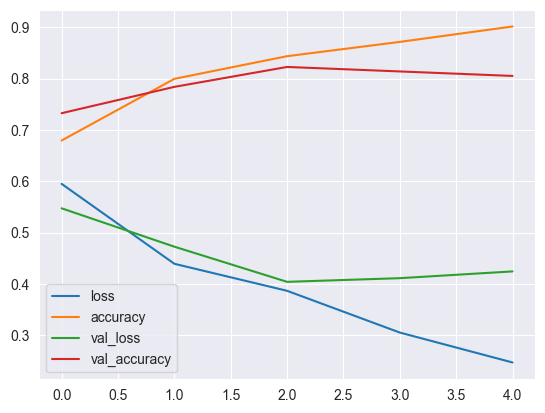

In [36]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame(hist.history)
df.plot(legend=True, grid=True)
plt.show()

In [37]:
data_root = 'models/model_lstm'
if not os.path.exists(data_root):
    os.mkdir(data_root)

In [38]:
# Listing 9.5 Save the model for later
model_structure = model.to_json()

with open(f"{data_root}/lstm_model1.json", "w") as json_file:
    json_file.write(model_structure)

model.save_weights(f"{data_root}/lstm_weights1.h5")
print('Model saved.')

Model saved.


<a name='9.1.2'></a><a id='9.1.2'></a>
## 9.1.2 Where does the rubber hit the road?
<a href="#top">[back to top]</a>

Problem: How does this LSTM model perform?

Idea: Test this model with various sample phrases for inference.

In [39]:
print("Load saved model")

with open(f"{data_root}/lstm_model1.json", "r") as json_file:
    json_string = json_file.read()
model = model_from_json(json_string)

model.load_weights(f'{data_root}/lstm_weights1.h5')

Load saved model


In [40]:
sample_1 = """I'm hate that the dismal weather that had me down for so long, 
when will it break! Ugh, when does happiness return?  
The sun is blinding and the puffy clouds are too thin.  
I can't wait for the weekend."""

In [41]:
# We pass a dummy value in the first element of the tuple just because our helper expects it from the way processed the initial data.  That value won't ever see the network, so it can be whatever.
vec_list = tokenize_and_vectorize([(1, sample_1)])

# Tokenize returns a list of the data (length 1 here)
test_vec_list = pad_trunc(vec_list, maxlen)

test_vec = np.reshape(test_vec_list, (len(test_vec_list), maxlen, embedding_dims))

In [42]:
# 0 = negative review, 1 = positive review
sentiment_imdb = []
sentiment_imdb.append('Negative Sentiment')
sentiment_imdb.append('Positive Sentiment')

In [43]:
y_pred = model.predict(test_vec)
print(y_pred)

1/1 [==============================] - 0s 431ms/step
[[0.4194814]]


In [44]:
# If model is binary classification, eg  sigmoid last-layer activation
res01 = (np.argmax(y_pred > 0.5))
print(res01)
sentiment_imdb[res01]

0


'Negative Sentiment'

<a name='9.1.3'></a><a id='9.1.3'></a>
## 9.1.3 Dirty data
<a href="#top">[back to top]</a>

Problem: What choices were made that compromised the integrity of the data?

Idea: We padded or truncated each sample to 400 tokens since it was important for convolutional nets so that filter could "scan" a vector with a consistent length. And convolutional nets output a consistent vector asd well. It's important for the output to be a consistent dimensionality, because the output goes into a fully connected feed forward layer at the end of the chain, which needs a fixed length vector as input. 

Also, our implementations of recurrent neural nets, both simple and LSTM, are striving toward a fixed length thought vector we can pass into a feed forward layer for classification. A fixed length vector representation of an object, such as a thought vector, is also an embedding. In order that the thought vector is a consistent size, we have to unroll the net to a consistent number of time steps (tokens). 

In [45]:
# Listing 9.8 Optimize the thought vector size
def test_len(data, maxlen):
    total_len = truncated = exact = padded = 0
    for sample in data:
        total_len += len(sample)
        if len(sample) > maxlen:
            truncated += 1
        elif len(sample) < maxlen:
            padded += 1
        else:
            exact +=1 

    print('Padded: {}'.format(padded))
    print('Equal: {}'.format(exact))
    print('Truncated: {}'.format(truncated))
    print('Avg length: {}'.format(total_len/len(data)))

dataset = pre_process_data(f"{data_imdb_path}/aclImdb/train")
vectorized_data = tokenize_and_vectorize(dataset)
test_len(vectorized_data, 400)

Padded: 3591
Equal: 1
Truncated: 408
Avg length: 204.67975


In [46]:
# Listing 9.9 Optimize LSTM hyperparameters
maxlen = 200 # Here we limit the max length to 200 tokens
batch_size = 32 # Amount of samples to show the net before backpropagating the error and updating the weights
embedding_dims = 300 # Length of token vectors we create for passing into the Convnet

epochs = 2

dataset = pre_process_data(f"{data_imdb_path}/aclImdb/train")
vectorized_data = tokenize_and_vectorize(dataset)
expected = collect_expected(dataset)

split_point = int(len(vectorized_data)*.8)

x_train = vectorized_data[:split_point]
y_train = expected[:split_point]
x_test = vectorized_data[split_point:]
y_test = expected[split_point:]

x_train = pad_trunc(x_train, maxlen)
x_test = pad_trunc(x_test, maxlen)

x_train = np.reshape(x_train, (len(x_train), maxlen, embedding_dims))
y_train = np.array(y_train)
x_test = np.reshape(x_test, (len(x_test), maxlen, embedding_dims))
y_test = np.array(y_test)

num_neurons = 50

In [47]:
# Listing 9.10 More optimally-sized LSTM
print('Build model...')
model = Sequential()

model.add(LSTM(num_neurons, return_sequences=True, input_shape=(maxlen, embedding_dims)))
model.add(Dropout(.2))

model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

model.compile('rmsprop', 'binary_crossentropy',  metrics=['accuracy'])
print(model.summary())

Build model...
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 200, 50)           70200     
                                                                 
 dropout_2 (Dropout)         (None, 200, 50)           0         
                                                                 
 flatten_2 (Flatten)         (None, 10000)             0         
                                                                 
 dense_2 (Dense)             (None, 1)                 10001     
                                                                 
Total params: 80,201
Trainable params: 80,201
Non-trainable params: 0
_________________________________________________________________
None


In [48]:
# Listing 9.11 Training a smaller LSTM
hist = model.fit(
    x_train, 
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test)
)

model_structure = model.to_json()

with open(f"{data_root}/lstm_model7.json", "w") as json_file:
    json_file.write(model_structure)

model.save_weights(f"{data_root}/lstm_weights7.h5")
print('Model saved.')

Epoch 1/2
100/100 [==============================] - 14s 120ms/step - loss: 0.5966 - accuracy: 0.6753 - val_loss: 0.7627 - val_accuracy: 0.6388
Epoch 2/2
100/100 [==============================] - 10s 104ms/step - loss: 0.4675 - accuracy: 0.7925 - val_loss: 0.4333 - val_accuracy: 0.7887
Model saved.


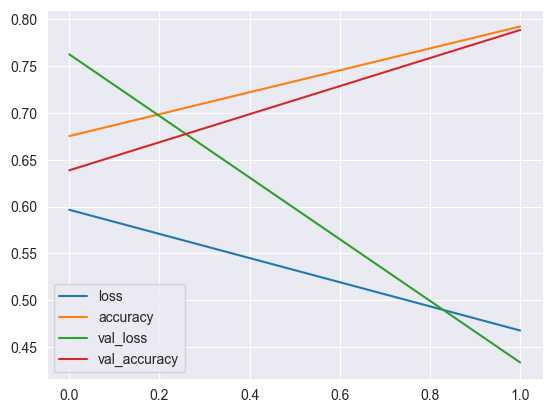

In [49]:
df = pd.DataFrame(hist.history)
df.plot(legend=True, grid=True)
plt.show()

<a name='9.1.4'></a><a id='9.1.4'></a>
## 9.1.4 Back to the dirty data
<a href="#top">[back to top]</a>

Problem: How can we deal with unknown words in a pretrained Word2vec model?

Idea: There are two basic approaches. The first involves replacing any unknown tokens with a randomly selected vector from the existing model, and using that instead. The second, more common approach is to replace all tokens not in the word vector library with a specific token, usually referenced as "UNK" (for unknown), when reconstructing the original input. As with padding, the network can learn its way around these unknown tokens and come to its conclusions around them. 

<a name='9.1.5'></a><a id='9.1.5'></a>
## 9.1.5 Words are hard. Letters are easier.
<a href="#top">[back to top]</a>

Problem: Word are not atomic at all, as they are made up of smaller words, stems, phonemes, and ultimately a sequence of characters, where a lot of meaning is hidden at.

Idea: Extract this deeper level of mearning by modeling at the character level.

Importance: Training a model at the character level can be difficult. The patterns and long-term dependencies found at the character level can vary greatly across voices. These patterns can be found, but they may not generalize well. 

In [50]:
# Listing 9.12 Prepare the data
dataset = pre_process_data(f"{data_imdb_path}/aclImdb/train")
expected = collect_expected(dataset)

In [51]:
# Listing 9.13 Calculate the average sample length
# Decide how far to unroll the network, in order to see how many characters
# on average are in the data samples.
def avg_len(data):
    total_len = 0
    for sample in data:
        total_len += len(sample[1])
    print(f"Average sample length: {total_len/len(data)}")
    
print(f"Average length of dataset: {avg_len(dataset)}")

Average sample length: 1340.40775
Average length of dataset: None


In [52]:
# Listing 9.14 Prepare the strings for a character-based model
# Clean the data of tokens unrelated to the text's natural language.
# This filters out some useless characters in the HTML tags, etc.
def clean_data(data):
    """ Shift to lower case, replace unknowns with UNK, and listify """
    new_data = []
    VALID = 'abcdefghijklmnopqrstuvwxyz123456789"\'?!.,:; '
    for sample in data:
        new_sample = []
        for char in sample[1].lower():  # Just grab the string, not the label
            if char in VALID:
                new_sample.append(char)
            else:
                # Use UNK as a single character for anything not matching the VALID list.
                new_sample.append('UNK')
       
        new_data.append(new_sample)
    return new_data

listified_data = clean_data(dataset)

In [53]:
len(listified_data)

4000

In [54]:
# Listing 9.15 Pad and truncate characters
# Pad or truncate samples to a given maxlen
# Here we introduce another single character for padding, PAD
def char_pad_trunc(data, maxlen):
    """ We truncate to maxlen or add in PAD tokens """
    new_dataset = []
    for sample in data:
        if len(sample) > maxlen:
            new_data = sample[:maxlen]
        elif len(sample) < maxlen:
            pads = maxlen - len(sample)
            new_data = sample + ['PAD'] * pads
        else:
            new_data = sample
        new_dataset.append(new_data)
    return new_dataset

# Use 1500 to capture slightly more data than was in the average sample.
# However, we want to avoid introducing too much noise with PADs.
maxlen = 1500

In [55]:
# Listing 9.16 Character-based model vocabulary.
# This time, instead of use word-embeddings, we one-hot encode the characters.
# We need to create a dictionary of the tokens (the characters) mapped to an integer value.
def create_dicts(data):
    """ Modified from Keras LSTM example"""
    chars = set()
    for sample in data:
        chars.update(set(sample))
    char_indices = dict((c, i) for i, c in enumerate(chars))
    indices_char = dict((i, c) for i, c in enumerate(chars))
    return char_indices, indices_char

In [56]:
# Listing 9.17 One-hot encoder for characters
# Use the above dictionary to create input vectors of the indices instead of 
# the tokens themselves. 
def onehot_encode(dataset, char_indices, maxlen):
    """ 
    One hot encode the tokens
    
    Args:
        dataset  list of lists of tokens
        char_indices  dictionary of {key=character, value=index to use encoding vector}
        maxlen  int  Length of each sample
    Return:
        np array of shape (samples, tokens, encoding length)
    """
    X = np.zeros((len(dataset), maxlen, len(char_indices.keys())))
    for i, sentence in enumerate(dataset):
        for t, char in enumerate(sentence):
            X[i, t, char_indices[char]] = 1
    return X

In [57]:
# Listing 9.18 Load and preprocess that IMDB data
dataset = pre_process_data(f"{data_imdb_path}/aclImdb/train")
expected = collect_expected(dataset)
listified_data = clean_data(dataset)

maxlen = 1500
common_length_data = char_pad_trunc(listified_data, maxlen)

char_indices, indices_char = create_dicts(common_length_data)
encoded_data = onehot_encode(common_length_data, char_indices, maxlen)

In [58]:
# Listing 9.19 Split the dataset for training and testing 
split_point = int(len(encoded_data)*.8)

x_train = encoded_data[:split_point]
y_train = expected[:split_point]
x_test = encoded_data[split_point:]
y_test = expected[split_point:]

In [59]:
# Listing 9.20 Build a character-based LSTM
num_neurons = 40

print('Build model...')
model = Sequential()

model.add(LSTM(num_neurons, return_sequences=True, input_shape=(maxlen, len(char_indices.keys()))))
model.add(Dropout(.2))

model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

model.compile('rmsprop', 'binary_crossentropy',  metrics=['accuracy'])
print(model.summary())

Build model...
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 1500, 40)          13920     
                                                                 
 dropout_3 (Dropout)         (None, 1500, 40)          0         
                                                                 
 flatten_3 (Flatten)         (None, 60000)             0         
                                                                 
 dense_3 (Dense)             (None, 1)                 60001     
                                                                 
Total params: 73,921
Trainable params: 73,921
Non-trainable params: 0
_________________________________________________________________
None


In [60]:
print(x_train.shape)
print(type(x_train))
HR()

# GB: May need to convert y_train to Numpy
y_train = np.array(y_train)
print(y_train.shape)
print(type(y_train))

(3200, 1500, 46)
<class 'numpy.ndarray'>
----------------------------------------
(3200,)
<class 'numpy.ndarray'>


In [61]:
y_test = np.array(y_test)

print(type(x_test))
print(x_test.shape)
print(type(y_test))

<class 'numpy.ndarray'>
(800, 1500, 46)
<class 'numpy.ndarray'>


In [62]:
# Listing 9.21 Train a character-based LSTM
batch_size = 32
epochs = 3

hist = model.fit(
    x_train[:1000], 
    y_train[:1000],
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_test[:1000], y_test[:1000])
)

Epoch 1/3
32/32 [==============================] - 27s 711ms/step - loss: 0.7986 - accuracy: 0.4930 - val_loss: 0.8258 - val_accuracy: 0.4975
Epoch 2/3
32/32 [==============================] - 26s 825ms/step - loss: 0.6234 - accuracy: 0.6830 - val_loss: 0.7405 - val_accuracy: 0.5050
Epoch 3/3
32/32 [==============================] - 25s 784ms/step - loss: 0.5242 - accuracy: 0.8210 - val_loss: 0.7474 - val_accuracy: 0.5188


In [63]:
# Listing 9.22 Save the model 
model_structure = model.to_json()
with open(f"{data_root}/char_lstm_model3.json", "w") as json_file:
    json_file.write(model_structure)

model.save_weights(f"{data_root}/char_lstm_weights3.h5")
print('Model saved.')

Model saved.


<a name='9.1.6'></a><a id='9.1.6'></a>
## 9.1.6 My turn to chat
<a href="#top">[back to top]</a>

Problem: How to generate new text with a given style?

Idea: Use a LSTM model to learn the probability of the next word based on what it just saw, but with the added benefit of memory state.

Importance: With the LSTM memory state, the model has a greater context in which to judge the most appropriate next term. This can help better predict the next character based on characters that came before. 

<a name='9.1.7'></a><a id='9.1.7'></a>
## 9.1.7 My turn to speak more clearly
<a href="#top">[back to top]</a>

Problem: What are the potential benefits of character-level modeling?

Idea: It may detect patterns around spelling, grammar, punctuation. In addition to learning these grammar details, it may also detect patterns around the rhythm and cadence of text as well. 

Importance: To effectively train for tone and word choice, it is necessary to have a dataset that is more consistent across samples in style and tone.

In [64]:
# Listing 9.23 Import the Project Gutenberg dataset
nltk.download('gutenberg')

gutenberg.fileids()

[nltk_data] Downloading package gutenberg to /Users/gb/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!


['austen-emma.txt',
 'austen-persuasion.txt',
 'austen-sense.txt',
 'bible-kjv.txt',
 'blake-poems.txt',
 'bryant-stories.txt',
 'burgess-busterbrown.txt',
 'carroll-alice.txt',
 'chesterton-ball.txt',
 'chesterton-brown.txt',
 'chesterton-thursday.txt',
 'edgeworth-parents.txt',
 'melville-moby_dick.txt',
 'milton-paradise.txt',
 'shakespeare-caesar.txt',
 'shakespeare-hamlet.txt',
 'shakespeare-macbeth.txt',
 'whitman-leaves.txt']

In [65]:
# Listing 9.24 Preprocess Shakespeare plays
# We select 3 plays and concatenate them into a large string.
text = ''

for txt in gutenberg.fileids():
    if 'shakespeare' in txt:
        text += gutenberg.raw(txt).lower()

print('corpus length:', len(text))

chars = sorted(list(set(text)))
print('total chars:', len(chars))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

corpus length: 375542
total chars: 50


In [66]:
print(text[:500])

[the tragedie of julius caesar by william shakespeare 1599]


actus primus. scoena prima.

enter flauius, murellus, and certaine commoners ouer the stage.

  flauius. hence: home you idle creatures, get you home:
is this a holiday? what, know you not
(being mechanicall) you ought not walke
vpon a labouring day, without the signe
of your profession? speake, what trade art thou?
  car. why sir, a carpenter

   mur. where is thy leather apron, and thy rule?
what dost thou with thy best apparrell on


In [67]:
# Listing 9.25 Assemble a training set
# Divide the text in semi-redundant sequences of maxlen characters
maxlen = 40
step = 3
sentences = []
next_chars = []

for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
    
print(f"nb sequences (training samples): {len(sentences):,}")

nb sequences (training samples): 125,168


In [68]:
# Listing 9.26 One-hot encode the training examples
print('Vectorization...')

X = np.zeros((len(sentences), maxlen, len(chars)), dtype=bool)
y = np.zeros((len(sentences), len(chars)), dtype=bool)

for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        X[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1
    
print("Done")

Vectorization...
Done


In [69]:
# This is the size of our last Dense layer in the model
len(chars)

50

In [70]:
# Listing 9.27 Assemble a character-based LSTM model for generating text
# Build the model: a single LSTM

print('Build model...')
model = Sequential()
model.add(LSTM(128, input_shape=(maxlen, len(chars))))
model.add(Dense(len(chars)))

# Because the last layer is a softmax, the output vector will be a probability
# distribution over all possible outputs of the network. By looking at the highest
# value in the output vector, we can see what the network thinks has the highest
# probability of being the next character. The index of the output vector with the
# highest value (between 0 and 1) will correlate with the index of the one-hot 
# encoding of the expected token.
model.add(Activation('softmax'))

optimizer = RMSprop(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)

print(model.summary())

Build model...
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 128)               91648     
                                                                 
 dense_4 (Dense)             (None, 50)                6450      
                                                                 
 activation (Activation)     (None, 50)                0         
                                                                 
Total params: 98,098
Trainable params: 98,098
Non-trainable params: 0
_________________________________________________________________
None


In [71]:
print(X.shape)
print(y.shape)

(125168, 40, 50)
(125168, 50)


In [73]:
# Listing 9.28 Train your Shakespearean chatbot
# Because we want to just model this dataset, we are not interested in generalizing
# to other problems, so overfitting is not only ok, it is desired.
epochs = 3
batch_size = 128

model_structure = model.to_json()
with open(f"{data_root}/shakes_lstm_model.json", "w") as json_file:
    json_file.write(model_structure)

for i in range(2): # 5
    model.fit(
        X[:10000], 
        y[:10000],
        batch_size=batch_size,
        epochs=epochs
    )

    model.save_weights(f"{data_root}/shakes_lstm_weights_{i+1}.h5")
    print('Model saved.')

Epoch 1/3
79/79 [==============================] - 7s 92ms/step - loss: 1.4009
Epoch 2/3
79/79 [==============================] - 7s 93ms/step - loss: 1.2553
Epoch 3/3
79/79 [==============================] - 10s 122ms/step - loss: 1.1105
Model saved.
Epoch 1/3
79/79 [==============================] - 13s 169ms/step - loss: 0.9901
Epoch 2/3
79/79 [==============================] - 7s 93ms/step - loss: 0.8781
Epoch 3/3
79/79 [==============================] - 7s 86ms/step - loss: 0.7876
Model saved.


In [74]:
### NOT IN CHAPTER, Just to reproduce output
with open(f'{data_root}/shakes_lstm_model.json', 'r') as f:
    model_json = f.read()

model = model_from_json(model_json)
model.load_weights(f'{data_root}/shakes_lstm_weights_4.h5')

In [75]:
# Listing 9.29 Sampler to generate character sequences
# Create our own play. The output vectors are 50-D vectors describing a 
# probability distribution over the 50 possible output characters, so we can
# sample from that distribution. Use a Keras helper function for that.

def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [76]:
# Listing 9.30 Generate three texts with three diversity levels
start_index = random.randint(0, len(text) - maxlen - 1)

for diversity in [0.2, 0.5, 1.0]:
    print()
    print('----- diversity:', diversity)

    generated = ''
    sentence = text[start_index: start_index + maxlen]
    generated += sentence
    print('----- Generating with seed:\n"' + sentence + '"')
    sys.stdout.write(generated)

    print()
    print()
    print("START")
    
    for i in range(400):
        x = np.zeros((1, maxlen, len(chars)))
        for t, char in enumerate(sentence):
            x[0, t, char_indices[char]] = 1.

        preds = model.predict(x, verbose=0)[0]
        next_index = sample(preds, diversity)
        next_char = indices_char[next_index]

        generated += next_char
        sentence = sentence[1:] + next_char

        sys.stdout.write(next_char)
        sys.stdout.flush()

    print()
    HR()


----- diversity: 0.2
----- Generating with seed:
"e:
it seemes it is as proper to our age,"
e:
it seemes it is as proper to our age,

START
 and thou say, when that to ande to dad haue to offente to sare the arest waue he would haue houed to me, is no flaut. see in thaue that is am sponde of the condowerestrorath when the read dad his wardes, wrue the read did farre woth was haue to mant winde, the arest my putton, wae ar he roue the papte of the may i mid the peare the are whe indow it is as fearie


  caes. that is was a crome: i wi
----------------------------------------

----- diversity: 0.5
----- Generating with seed:
"e:
it seemes it is as proper to our age,"
e:
it seemes it is as proper to our age,

START
 in oure the maye the reat now may,
wores a shaue of a haue

   bru. ine, wellow this a know your stue the manth his caliosio that you, winde to your some vs all i mar he for did nage: it is a  frame, and yeur frith wem bus your sould mangerauld cassar fath nabe

   fre nat h

<a name='9.1.8'></a><a id='9.1.8'></a>
## 9.1.8 Learned how to say, but no yet what
<a href="#top">[back to top]</a>

Problem: What is the limitation of the model we just created?

Idea: We can generate new text, but cannot control the content, only the style.

<a name='9.1.9'></a><a id='9.1.9'></a>
## 9.1.9 Other kinds of memory
<a href="#top">[back to top]</a>

Problem: What other types of RNN/LSTM derivatives exist?

Idea: GRU, and LSTM with *peephole* conections. These are slight variations on the number or operations of the gates inside the cell. The GRU combines the forget gate and candidate choice branch into a single gate. The LSTM with peephole connections enables each gate in a standard LSTM cell to have access to the current memory state directly, taken in as part of its input. 

In [77]:
# Listing 9.31 Gated recurrent units in Keras
model = Sequential()
model.add(GRU(num_neurons, return_sequences=True, input_shape=X[0].shape))

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 40, 40)            11040     
                                                                 
Total params: 11,040
Trainable params: 11,040
Non-trainable params: 0
_________________________________________________________________


<a name='9.1.10'></a><a id='9.1.10'></a>
## 9.1.10 Going deeper
<a href="#top">[back to top]</a>

Problem: What is advantage of stacking LSTM layers?

Idea: This enables the model to form more complex representations of the patterns in the training data. These stacked layers are much more computationally expensive to train. In Keras, we have to specify `return_sequences=True` since the output at each time step is needed as the input for the time steps of the next layer.

In [78]:
# Listing 9.32 Two LSTM layers
model = Sequential()
model.add(LSTM(num_neurons, return_sequences=True, input_shape=X[0].shape))
model.add(LSTM(num_neurons, return_sequences=True))
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 40, 40)            14560     
                                                                 
 lstm_6 (LSTM)               (None, 40, 40)            12960     
                                                                 
Total params: 27,520
Trainable params: 27,520
Non-trainable params: 0
_________________________________________________________________
